# Example ESASky use

This notebook illustrates some relatively more advanced usages of the ESASky implementation as a module of  `astroquery`.

Authors: Ivan Valtchanov, Nuria Álvarez and Henrik Norman.

First you need to install `astroquery` which contains esasky.

Astroquery can be installed with `pip install --pre astroquery`, the latest version should come with esasky. 

The documentation for `astroquery.esasky` is available [here](https://astroquery.readthedocs.io/en/latest/esasky/esasky.html).

### Modification history:
* Notebook updated to reflect backend changes as of July 2021.


In [1]:
#
# import some necessary packages
#
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from astropy.io import fits
%matplotlib inline

import numpy as np

from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize, AsinhStretch, LogStretch, LinearStretch
from astroquery.esasky import ESASky
from astropy.convolution import convolve, Kernel, Gaussian2DKernel

Created TAP+ (v20200428.1) - Connection:
	Host: sky.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Workflow

This is a simple workflow.

1. Load an XMM-Newton EPIC image of a target of choice.
2. Smooth the image with a Gaussian with FWHM=5".
3. Generate 10 contours.
4. Plot the original photon image in [0.2-7] keV (ESASky data) and overplot the contours.
5. Load a Herschel 250 µm image of the same target.
6. Plot the Herschel image and overplot the XMM smoothed image contours.
7. Overplot the Planck PSZ catalogue sources.

In [2]:
ESASky.list_maps()

['INTEGRAL',
 'XMM',
 'Chandra',
 'SUZAKU',
 'XMM-OM-OPTICAL',
 'XMM-OM-UV',
 'HST-UV',
 'HST-OPTICAL',
 'HST-IR',
 'ISO-IR',
 'Herschel',
 'AKARI',
 'Spitzer',
 'ALMA']

In [3]:
maps = ESASky.query_object_maps(position='M51', missions=["XMM","HERSCHEL"])
print (maps)

TableList with 2 tables:
	'0:XMM' with 15 column(s) and 11 row(s) 
	'1:HERSCHEL' with 15 column(s) and 9 row(s) 


In [4]:
ESASky.list_catalogs()

['LAMOST',
 'AllWise',
 'AKARI-IRC-SC',
 'TwoMASS',
 'INTEGRAL',
 'CHANDRA-SC2',
 'XMM-EPIC-STACK',
 'XMM-EPIC',
 'XMM-OM',
 'XMM-SLEW',
 'Tycho-2',
 'Gaia-eDR3',
 'Hipparcos-2',
 'HSC',
 'Herschel-HPPSC-070',
 'Herschel-HPPSC-100',
 'Herschel-HPPSC-160',
 'Herschel-SPSC-250',
 'Herschel-SPSC-350',
 'Herschel-SPSC-500',
 'Planck-PGCC',
 'Planck-PCCS2E-HFI',
 'Planck-PCCS2-HFI',
 'Planck-PCCS2-LFI',
 'Planck-PSZ2']

In [5]:
#
# get information on the content of the results table returned by the query
#
print(maps["XMM"].info)

<Table length=11>
      name       dtype  unit                         description                         
--------------- ------- ---- ------------------------------------------------------------
        dec_deg float64  deg                                                             
       duration   int64    s                           Total exposure time of observation
       end_time  object time                                         Observation End Time
            fov  object                                                                  
     instrument  object                                                        Instrument
           npix   int64      Healpix pixel of the center of the observation for nside 256
 observation_id  object                         The XMM-Newton observation identification
observation_oid   int32                                   Observation internal identifier
 position_angle float64                                                           

In [6]:
maps_list = ESASky.list_maps()
maps_list

['INTEGRAL',
 'XMM',
 'Chandra',
 'SUZAKU',
 'XMM-OM-OPTICAL',
 'XMM-OM-UV',
 'HST-UV',
 'HST-OPTICAL',
 'HST-IR',
 'ISO-IR',
 'Herschel',
 'AKARI',
 'Spitzer',
 'ALMA']

In [7]:
#
# and list the observations and their duration
#
maps["XMM"]["observation_id","instrument","duration"].pprint()

observation_id instrument duration
                             s    
-------------- ---------- --------
    0112840201       EPIC    20916
    0212480801       EPIC    49214
    0303420201       EPIC    36809
    0677980701       EPIC    13319
    0677980801       EPIC    13317
    0824450901       EPIC    78000
    0830191601       EPIC    63000
    0852030101       EPIC    77000
    0303420101       EPIC    54114
    0830191401       EPIC    98000
    0830191501       EPIC    63000


We only need one of the XMM observation, let's take the longest one: 0830191401, it is with index 9.

In [8]:
# need to copy if you don't want to modify the original maps
nxmm = len(maps["XMM"])
maps["XMM"].remove_rows(np.delete(range(nxmm),9))
maps["XMM"]["observation_id","duration"].pprint()

observation_id duration
                  s    
-------------- --------
    0830191401    98000


Now let's select the Herschel 250 µm map before we submit the download request to ESASky.

In [9]:
print (maps["HERSCHEL"].info)
maps["HERSCHEL"]["observation_id","filter","duration"].pprint()

<Table length=9>
        name         dtype    unit                     description                   
------------------- ------- ------- -------------------------------------------------
            dec_deg float64     deg                    Actual declination of pointing
           duration float64 seconds            Duration of the observation in seconds
           end_time  object                  The end date and time of the observation
             filter  object microns                            Filter or filters used
                fov  object                                             Field of view
         instrument  object                                   The Herschel instrument
     observation_id  object                  The identifier of a Herschel observation
    observation_oid   int32                                     Database index number
observing_mode_name  object                       Name of the Herschel observing mode
       postcard_url  object          

Let's pick up SPIRE observation 1342188589, this is index 6. 

In [10]:
nher = len(maps["HERSCHEL"])
maps["HERSCHEL"].remove_rows(np.delete(range(nher),6))
maps["HERSCHEL"]["observation_id","filter","duration"].pprint()

observation_id     filter    duration
                  microns    seconds 
-------------- ------------- --------
    1342188589 250, 350, 500   1577.0


And we are ready to download the maps. They will be available in the memory but also saved to the default folder.

In [11]:
maps_data = ESASky.get_maps(query_table_list=maps)

INFO: Starting download of XMM data. (1 files) [astroquery.esasky.core]
INFO: Downloading Observation ID: 0830191401 from http://nxsa.esac.esa.int/nxsa-sl/servlet/data-action?RETRIEVAL_TYPE=PRODUCT&OBS_IMAGE_TYPE=OBS_EPIC&PROTOCOL=HTTP&OBSERVATION_ID=0830191401 [astroquery.esasky.core]
INFO: [Done] [astroquery.esasky.core]
INFO: Downloading of XMM data complete. [astroquery.esasky.core]
INFO: Starting download of HERSCHEL data. (1 files) [astroquery.esasky.core]
INFO: Downloading Observation ID: 1342188589 from http://archives.esac.esa.int/hsa/whsa-tap-server/data?RETRIEVAL_TYPE=STANDALONE&observation_oid=8618001&DATA_RETRIEVAL_ORIGIN=UI [astroquery.esasky.core]
INFO: [Done] [astroquery.esasky.core]
INFO: Downloading of HERSCHEL data complete. [astroquery.esasky.core]
INFO: Maps available at /Users/nalvarez/Documents/ESDC/astroquery/Maps. [astroquery.esasky.core]


Let's have a look at the _Herschel_ maps_data. As we only kept one observation then there will be only one set of maps (index=0) and they will be stored in a dictionary with keys '250', '350' and '500'.

In [12]:
print (maps_data["HERSCHEL"][0].keys())

dict_keys(['250', '350', '500'])


And then the XMM maps_data, which is also for one entry (index=0) but it's only one map in a Primary HDU.

In [13]:
print (maps_data["XMM"][0])

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fdb3229c340>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fdb368f3eb0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fdb36291ca0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fdb36292160>]


Let's check the HDUs.

In [14]:
#
# XMM
#
xmm_hdu = maps_data["XMM"][0]
xmm_hdu.info()

Filename: Maps/XMM/P0830191401EPX0003COLIM8000.FTZ
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (648, 648, 3)   float32   
  1  RAWIMAGE      1 ImageHDU        34   (648, 648, 3)   float32   
  2  FWCIMAGE      1 ImageHDU        34   (648, 648, 3)   float32   
  3  OOTIMAGE      1 ImageHDU        34   (648, 648, 3)   float32   


The XMM image is 3-D with different 3-D extensions. The content of the 3-color FITS files from the XMM pipeline is explained in the [XMM Pipeline Specification Document](https://xmm-tools.cosmos.esa.int/external/xmm_obs_info/odf/data/docs/XMM-SOC-GEN-ICD-0024.pdf). The primary extension is the background and exposure corrected image of MOS1+MOS2+pn; `RAWIMAGE` is the count-rate image, `FWCIMAGE` is the background image (Filter-Wheel-Closed data), `OOTIMAGE` is the Out-of-Time events image.

The PRIMARY extension contains images with three energy bands: `0 => [0.3,0.7] keV`, `1 => [0.7,1.2] keV` and `2 => [1.2,7.0] keV`. These are produced with [`etruecolor`](http://xmm-tools.cosmos.esa.int/external/sas/current/doc/etruecolor/index.html) XMM-SAS task. 

For the tests we'll use the second slice (the "green" image, [0.7,1.2] keV) and the `RAWIMAGE` extension.

**Note** The FITS HDU info displays the dimensions of each extension as (648,648,3), but when we extract slices (i.e. per band) in python the band dimension is the first one, i.e. to get the image in band [0.3,0.7] keV use `hdu['RAWIMAGE'].data[0,:,:]`. 

In [15]:
#
# Herschel
#
her_hdu = maps_data["HERSCHEL"][0]["250"]
her_hdu.info()

Filename: Maps/HERSCHEL/anonymous1627462151/hspirepsw1342188589_20pxmp_1461102011773.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     169   ()      
  1  image         1 ImageHDU        47   (422, 445)   float64   
  2  error         1 ImageHDU        47   (422, 445)   float64   
  3  coverage      1 ImageHDU        47   (422, 445)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   79R x 1C   [326A]   
  6  HistoryTasks    1 BinTableHDU     46   59R x 4C   [1K, 27A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   328R x 10C   [1K, 20A, 13A, 196A, 1L, 1K, 1L, 74A, 11A, 41A]   


The Herschel HDU contains a lot of extensions, with `image`, `error` and `coverage`.

Now we have the maps loaded in the session and we can start with some of the points in the workflow.

1. Smooth the XMM-EPIC map with a Gaussian with FWHM=5"

Because the data is 3-D, the WCS is also 3-D and we have to slice it and extract the sliced WCS. 

In [16]:
# need to crate the Gaussian kernel, it needs the st.dev. in pixels, so we need to get the WCS of the image first
wcs = WCS(xmm_hdu[0].header)
#
# slice and extract the WCS
#
w = wcs.dropaxis(2)
pix = w.wcs.cdelt[1]*3600.0 # pixel size in arcsec
#
g_image = xmm_hdu['RAWIMAGE'].data[1,:,:]
#
fwhm = 15.0/pix
conv = np.sqrt(8.0*np.log(2.0))
stdev = fwhm/conv
gauss = Gaussian2DKernel(x_stddev=stdev, y_stddev=stdev)
xmm_sm5 = convolve(g_image,gauss)

Let's visualise the "green" ([0.7,1.2] keV) XMM `RAWIMAGE` extension and add contours from the smoothed image.

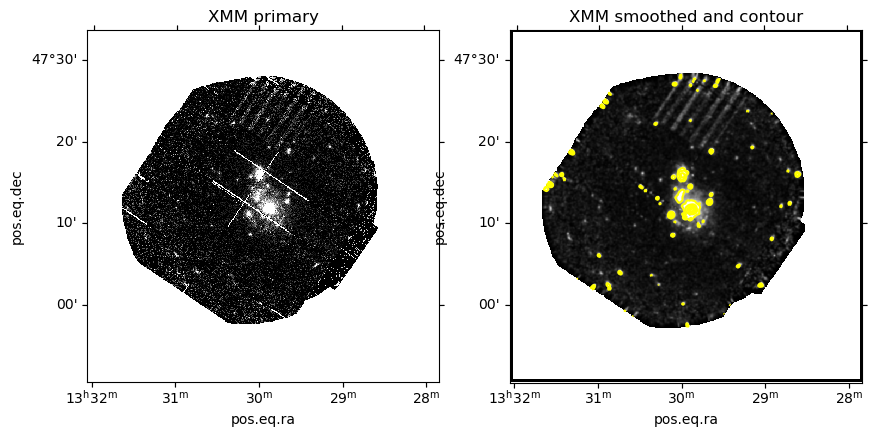

In [17]:
fig = plt.figure(figsize=(10,10),dpi=100)
pp = 98.0 # colour cut percentage
ax = fig.add_subplot(121,projection=w)
ax.set_title("XMM primary")
norm = ImageNormalize(g_image,interval=PercentileInterval(pp), stretch=LinearStretch())
ax.imshow(g_image,cmap=plt.cm.gray,origin='lower',norm=norm,interpolation='nearest')
ay = fig.add_subplot(122,projection=w)
ay.set_title("XMM smoothed and contour")
norm = ImageNormalize(xmm_sm5,interval=PercentileInterval(pp), stretch=LinearStretch())
ay.imshow(xmm_sm5,cmap=plt.cm.gray,norm=norm,origin='lower',interpolation='nearest')
#print (np.min(xmm_sm5),np.max(xmm_sm5))
# now plot the contours
ay.contour(xmm_sm5, transform=ay.get_transform(w), 
           levels=np.logspace(-4,-1,10),colors='yellow')

Now, let's show the Herschel 250 µm image.

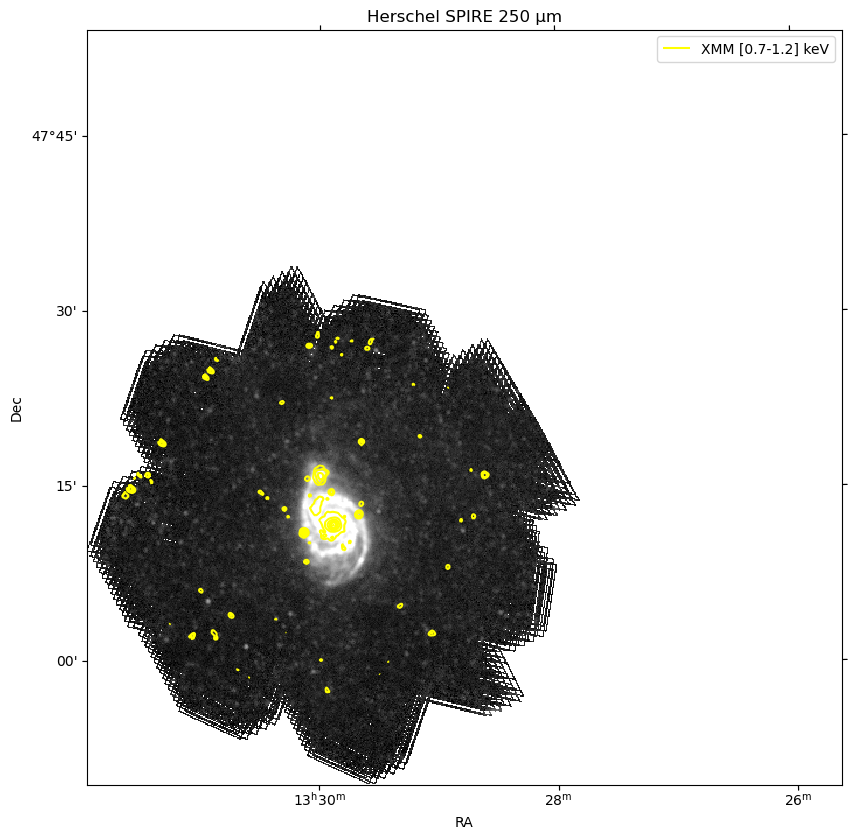

In [18]:
fig = plt.figure(figsize=(10,10),dpi=100)
pp = 98.0 # colour cut percentage
wcs_h = WCS(her_hdu['image'].header)
ax = fig.add_subplot(111,projection=wcs_h)
ax.set_title("Herschel SPIRE 250 µm")
norm_her = ImageNormalize(her_hdu['image'].data[~np.isnan(her_hdu['image'].data)],interval=PercentileInterval(pp), stretch=AsinhStretch())
ax.imshow(her_hdu['image'].data,cmap=plt.cm.gray,norm=norm_her,origin='lower',interpolation='nearest')
cs = ax.contour(xmm_sm5, transform=ax.get_transform(w), 
           levels=np.logspace(-4,-1,10),colors='yellow')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
#
ax.legend([q for q in cs.collections],["XMM [0.7-1.2] keV"]);

Now, let's load some catalogues.

In [19]:
cats = ESASky.query_region_catalogs(position='M51', radius='10 arcmin')
print (cats)

TableList with 18 tables:
	'0:LAMOST' with 49 column(s) and 41 row(s) 
	'1:ALLWISE' with 25 column(s) and 1762 row(s) 
	'2:AKARI-IRC-SC' with 29 column(s) and 1 row(s) 
	'3:TWOMASS' with 14 column(s) and 188 row(s) 
	'4:CHANDRA-SC2' with 41 column(s) and 430 row(s) 
	'5:XMM-EPIC-STACK' with 345 column(s) and 214 row(s) 
	'6:XMM-EPIC' with 220 column(s) and 823 row(s) 
	'7:XMM-OM' with 122 column(s) and 4849 row(s) 
	'8:XMM-SLEW' with 105 column(s) and 2 row(s) 
	'9:GAIA-EDR3' with 100 column(s) and 932 row(s) 
	'10:HSC' with 27 column(s) and 10000 row(s) 
	'11:HERSCHEL-HPPSC-070' with 21 column(s) and 93 row(s) 
	'12:HERSCHEL-HPPSC-100' with 21 column(s) and 122 row(s) 
	'13:HERSCHEL-HPPSC-160' with 21 column(s) and 93 row(s) 
	'14:HERSCHEL-SPSC-250' with 36 column(s) and 59 row(s) 
	'15:HERSCHEL-SPSC-350' with 36 column(s) and 24 row(s) 
	'16:HERSCHEL-SPSC-500' with 36 column(s) and 7 row(s) 
	'17:PLANCK-PCCS2-HFI' with 9 column(s) and 8 row(s) 


In [20]:
catx= cats['PLANCK-PCCS2-HFI']
print(catx.info)

<Table length=8>
          name           dtype    unit                                                                          description                                                                         
----------------------- ------- ------- ------------------------------------------------------------------------------------------------------------------------------------------------------------
                    dec float64     deg                                                                                                                                Declination of source (J2000)
                detflux float32     mJy                                                                                                                                         Channel flux density
            detflux_err float32     mJy                                                                                                                      Error (1 sigma) in channel flux densit

Select only the 857 GHz sources.

In [21]:
ix857 = np.where(catx['frequency'] == 857)[0]
src857 = catx[ix857]
src857

dec,detflux,detflux_err,extended,frequency,highest_reliability_cat,name,pos,ra
deg,mJy,mJy,,GHz,,,radians,deg
float64,float32,float32,int32,int32,int32,object,object,float64
47.269458738155556,2487.3816,144.50739,1,857,99,PCCS2 857 G104.70+68.45,"(3.53615979924974 , 0.825007690616419)",202.60703218083844
47.29270496686151,8509.699,148.8071,1,857,99,PCCS2 857 G104.89+68.46,"(3.5343989454277 , 0.825413413846009)",202.50614268849597
47.078154678280164,1935.9907,154.44075,1,857,99,PCCS2 857 G104.65+68.65,"(3.5344220449104 , 0.821668804899161)",202.50746619136382
47.181795866475426,46454.07,382.1489,1,857,99,PCCS2 857 G104.80+68.56,"(3.53405763720841 , 0.823477684873847)",202.4865871680179


Now let's combine everything into a final figure.

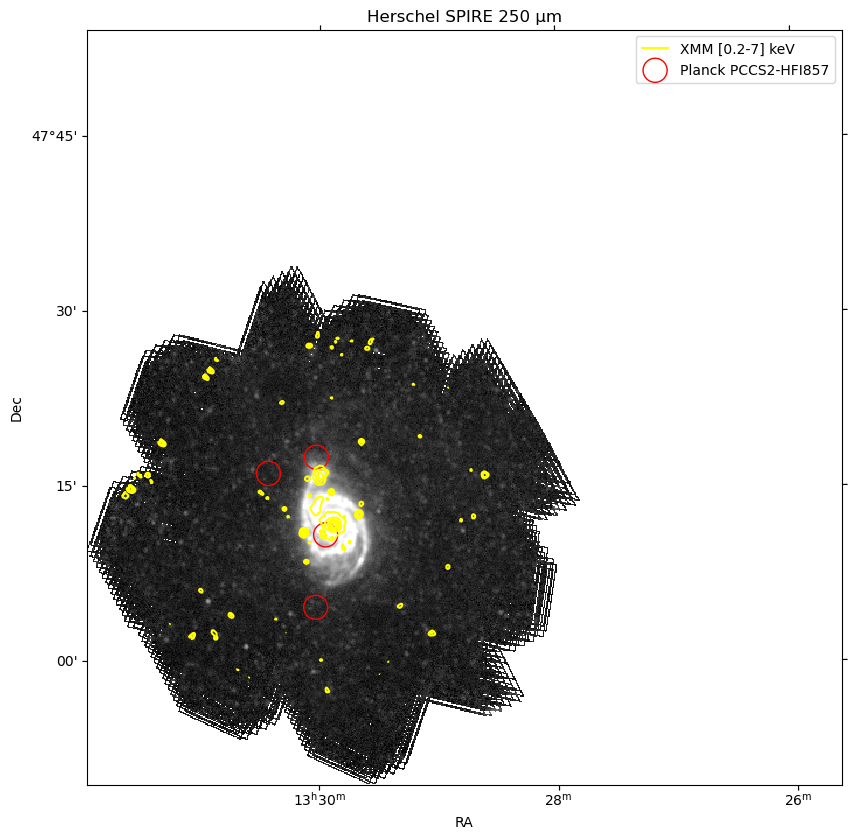

In [22]:
fig = plt.figure(figsize=(10,10),dpi=100)
pp = 95.0 # colour cut percentage
wcs_h = WCS(her_hdu['image'].header)
ax = fig.add_subplot(111,projection=wcs_h)
ax.set_title("Herschel SPIRE 250 µm")
ax.imshow(her_hdu['image'].data,cmap=plt.cm.gray,norm=norm_her,origin='lower',interpolation='nearest')
cs = ax.contour(xmm_sm5, transform=ax.get_transform(w), 
           levels=np.logspace(-4,-1,10),colors='yellow')
p1 = ax.scatter(src857['ra'],src857['dec'],transform=ax.get_transform('world'), \
        s=300, edgecolor='red', facecolor='none', label='Planck PCCS2-HFI')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.legend([[q for q in cs.collections][0],p1],["XMM [0.2-7] keV","Planck PCCS2-HFI857"]);

### Final notes

This simple example illustrated a simple usage of the esasky module wihtin astroquery and showed how to use ESA's archival data on XMM-EPIC, Herschel-SPIRE and Planck point source catalogue.

The final figure in the example shows some potential quality issues with the Planck PCCS2-HFI as the sources seem to be offset from the centre of M51 (NGC 5194) and its sattelite M51B (NGC 5195). 

There is a relatively good match between the SPIRE 250 µm map and the XMM-EPIC contours. 